# Lane Lines Detection

## I. Lane Lines Detection on Image 

In [25]:
# Setup import the required library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.interpolate as interpolate
import cv2
from PIL import Image

# Pipeline function to process image
def pipeline(image, output_file, show_image=False, ):
    # Grayscale image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian smoothing to reduce noise
    blur_gray = cv2.GaussianBlur(gray,(5, 5),0)
    if show_image:
        plt.imshow(blur_gray, cmap='gray')
        plt.show()
    
    # Cannyfy to extract edges
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    if show_image:
        plt.imshow(edges)
        plt.show()

    # Create a polygon mask to select region of interest
    # Here I divided them into two sections for easier averaging post-Hough
    ignore_mask_color = 255   
    imshape = image.shape
    
    mask_left = np.zeros_like(edges)   
    vertices_left = np.array([[(0,imshape[0]),(450, imshape[0]*0.6), (475, imshape[0]*0.6), (475,imshape[0])]], dtype=np.int32)
    mask_right = np.zeros_like(edges)   
    vertices_right = np.array([[(475,imshape[0]),(475, imshape[0]*0.6), (500, imshape[0]*0.6), (imshape[1],imshape[0])]], dtype=np.int32)
    
    cv2.fillPoly(mask_left, vertices_left, ignore_mask_color)
    masked_edges_left = cv2.bitwise_and(edges, mask_left)
    
    cv2.fillPoly(mask_right, vertices_right, ignore_mask_color)
    masked_edges_right = cv2.bitwise_and(edges, mask_right)
    
    if show_image:
        plt.imshow(masked_edges_left)
        plt.show()
        plt.imshow(masked_edges_right)
        plt.show()
    
    # Define the Hough transform parameters
    # Hough parameters setup
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = 2*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 300    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    copy_image = np.copy(image) # create another copy for the line drawing at the end
    
    # Run Hough on edge detected
    # Output "lines" is an array containing endpoints of detected line segments
    lines_left = cv2.HoughLinesP(masked_edges_left, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    lines_right = cv2.HoughLinesP(masked_edges_right, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    
    # Average, then interpolate to get the general estimate
    lines_average_left = np.mean(lines_left, axis=0, dtype=np.int32)
    line_function_left = interpolate.InterpolatedUnivariateSpline([lines_average_left[0][0], lines_average_left[0][2]], [lines_average_left[0][1], lines_average_left[0][3]], k=1)
    lines_left_extended = [np.array([0, int(line_function_left(0)), lines_average_left[0][2], lines_average_left[0][3]])]
    
    lines_average_right = np.mean(lines_right, axis=0, dtype=np.int32)
    line_function_right = interpolate.InterpolatedUnivariateSpline([lines_average_right[0][0], lines_average_right[0][2]], [lines_average_right[0][1], lines_average_right[0][3]], k=1)
    lines_right_extended = [np.array([imshape[1], int(line_function_right(imshape[1])), lines_average_right[0][0], lines_average_right[0][1]])]
    
    lines = np.append([lines_left_extended], [lines_right_extended], axis=0)

    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            cv2.line(copy_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

#     # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

    plt.imshow(lines_edges)
    plt.show()
    plt.imshow(copy_image)
    plt.show()
    
    # To save the images(s)
#     im = Image.fromarray(lines_edges)
#     im.save(output_file)

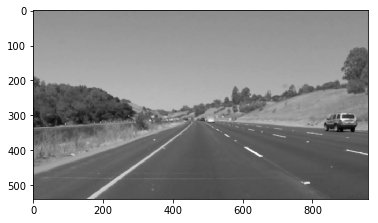

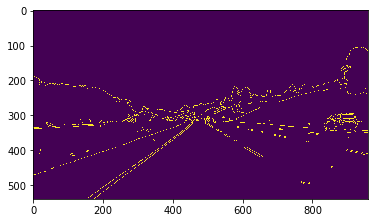

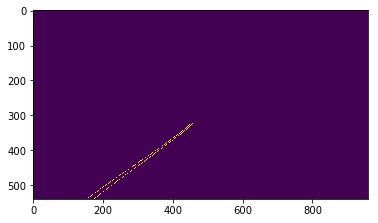

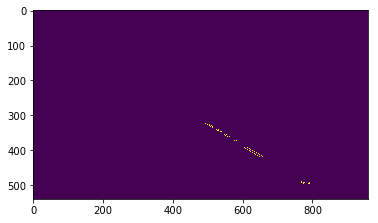

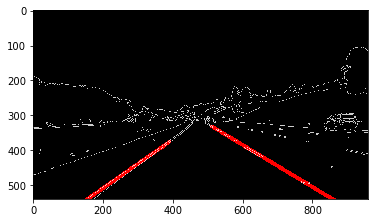

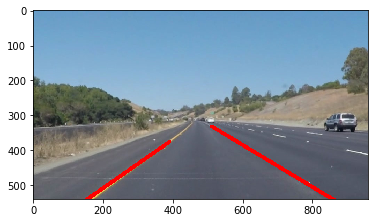

In [26]:
# First image test
pipeline(mpimg.imread('./test_images/solidYellowCurve.jpg'), 'solidYellowCurve.png', True)

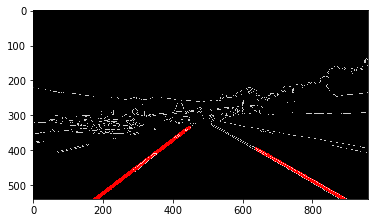

In [3]:
pipeline(mpimg.imread('./test_images/solidWhiteCurve.jpg'), 'solidWhiteCurve.png')

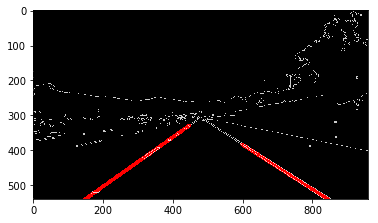

In [4]:
pipeline(mpimg.imread('./test_images/solidWhiteRight.jpg'), 'solidWhiteRight.png')

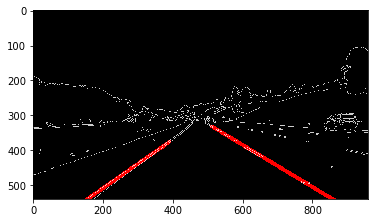

In [5]:
pipeline(mpimg.imread('./test_images/solidYellowCurve.jpg'), 'solidYellowCurve.png')

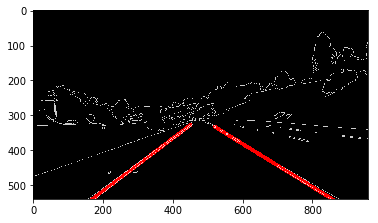

In [6]:
pipeline(mpimg.imread('./test_images/solidYellowCurve2.jpg'), 'solidYellowCurve2.png')

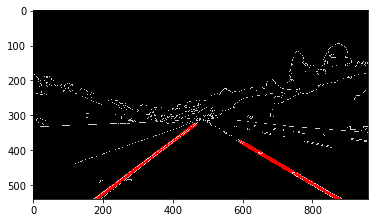

In [10]:
pipeline(mpimg.imread('./test_images/whiteCarLaneSwitch.jpg'), 'whiteCarLaneSwitch.png')

## II. Lane Lines Detection in Video

In [12]:
# Time to process the video. 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
# # Create a new video file
new_clip_output = 'test_output.mp4'
test_clip = VideoFileClip("./test_videos/solidWhiteRight.mp4")
# new_clip = test_clip.fl_image(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV)) #NOTE: this function expects color images!!
# %time new_clip.write_videofile(new_clip_output, audio=False)

In [ ]:
# # Render
# HTML("""
# <video width="640" height="300" controls>
#   <source src="{0}" type="video/mp4">
# </video>
# """.format(new_clip_output))